In [1]:
import torch
import os
import io
import sys
import csv
import six
import itertools
import collections
import argparse
from glob import glob
import numpy as np
import pandas as pd

from torchtext.vocab import Vectors, Vocab
from collections import Counter, defaultdict, OrderedDict

from model import IQN
from trainer import Trainer
from utils import MyDataset

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

LOG_DIR = os.path.join('.', 'logs')
NEWS_PATH = os.path.join('..', 'data', 'news')

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=10)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=50)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.0)
parser.add_argument('--learning_rate', type=float, default=2.5e-4)

parser.add_argument('--test', action='store_true')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

parser.add_argument('--num_quantile', type=int, default=32)

args = parser.parse_args(args=[])

args.rnn = False

torch.backends.cudnn.benchmark = True

In [3]:
# Create Dataset
train_ds = MyDataset(
    path=os.path.join('..', 'data', 'news', 'text_train.tsv'),
    vocab=None,
    specials=['<company>', '<organization>', '<person>', '<location>'],
    max_len=args.max_length
)

japanese_fasttext_vectors = Vectors(name='../data/news/cc.ja.300.vec')

train_ds.build_vocab(
    vectors=japanese_fasttext_vectors,
    min_freq=args.min_freq
)

test_ds = MyDataset(
    path=os.path.join('..', 'data', 'news', 'text_test.tsv'),
    vocab=train_ds.vocab,
)

train_dl = torch.utils.data.DataLoader(
    train_ds, 
    batch_size = 1, 
    shuffle = False, 
    num_workers = 3
)

test_dl = torch.utils.data.DataLoader(
    test_ds, 
    batch_size = 1,
    shuffle = False
)

In [4]:
text_vectors = train_ds.vocab.vectors
vocab_size = len(train_ds.vocab.vectors)

trainer = Trainer(args, text_vectors, vocab_size, train_dl)
trainer.load_model()
trainer.model.eval()

IQN(
  (embedding): Embedding(1493, 300)
  (phi): Linear(in_features=64, out_features=64, bias=True)
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
      (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
    )
    (fc0): Linear(in_features=150, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (rnn): RNN(
    (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
    (attn): Attn(
      (fc): Sequential(
        (0): Linear(in_features=50, out_features=24, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=24, out_features=1, bias=True)
      )
    )
    (fc0): Linear(in_features=50, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_q): Linear(in_features=64, o

#  シミュレーション

## 通常

In [5]:
curr_q = []
risk_neutral_q = []
risk_sensitive_q = []
risk_averse_q = []
rewards = []
attns = []
states = []
codes = []
dates = []

eta0 = 0
eta1 = 1

for batch in test_dl:
    state = batch['State'].to(device)
    with torch.no_grad():
        risk_neutral, _, attn = trainer.model(state, eta0, eta1, eval=True)
        risk_sensitive, _, _ = trainer.model(state, eta0, 0.1, eval=True)
        risk_averse, _, _ = trainer.model(state, 0.9, eta1, eval=True)

    risk_neutral_q.append(risk_neutral.squeeze(2).cpu().numpy())
    risk_sensitive_q.append(risk_sensitive.squeeze(2).cpu().numpy())
    risk_averse_q.append(risk_averse.squeeze(2).cpu().numpy())

    attns.append(attn.squeeze(2).cpu().numpy())
    rewards.append(batch['Reward'].item())
    states.append(state.cpu().numpy())
    codes.append(batch['Code'][0])
    dates.append(batch['Date'][0])

risk_neutral_q = np.array(risk_neutral_q)
risk_sensitive_q = np.array(risk_sensitive_q)
risk_averse_q = np.array(risk_averse_q)

attns = np.array(attns)
rewards = np.array(rewards)
states = np.array(states)

In [6]:
risk_neutral_q = np.array(risk_neutral_q).reshape(-1, args.num_quantile)
risk_sensitive_q = np.array(risk_sensitive_q).reshape(-1, args.num_quantile)
risk_averse_q = np.array(risk_averse_q).reshape(-1, args.num_quantile)
attns = np.array(attns).reshape(-1, args.max_length)
states = np.array(states).reshape(-1, args.max_length)

In [7]:
indexes = []
for x, y in zip(dates, codes):
    indexes.append([x, y])

df = pd.DataFrame(
    index=sorted(set(dates)), 
    columns=sorted(list(set(codes))))

for d, c, r in zip(dates, codes, rewards):
    df.loc[d, c] = r
df = df.fillna(0)

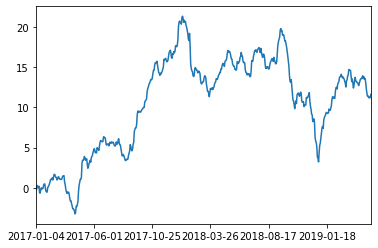

In [8]:
df.mean(axis=1).cumsum().plot()

# リスクニュートラル

In [9]:
mean_risk_neutral = np.mean(risk_neutral_q, axis=1)
actions = np.where(mean_risk_neutral > 0, 1, 0)
epi_rewards = (rewards * actions)

df_neutral = pd.DataFrame(
    index=sorted(set(dates)), 
    columns=sorted(list(set(codes))))

for d, c, r in zip(dates, codes, epi_rewards):
    df_neutral.loc[d, c] = r
df_neutral = df_neutral.fillna(0)

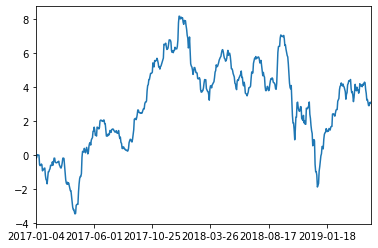

In [10]:
df_neutral.mean(axis=1).cumsum().plot()

In [11]:
median_risk_neutral = np.mean(risk_neutral_q, axis=1)
actions = np.where(median_risk_neutral > 0, 1, 0)
epi_rewards = (rewards * actions)

df_neutral = pd.DataFrame(
    index=sorted(set(dates)), 
    columns=sorted(list(set(codes))))

for d, c, r in zip(dates, codes, epi_rewards):
    df_neutral.loc[d, c] = r
df_neutral = df_neutral.fillna(0)

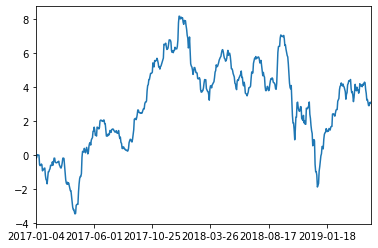

In [12]:
df_neutral.mean(axis=1).cumsum().plot()

In [13]:
mean_risk_neutral = np.mean(risk_neutral_q, axis=1)
std_risk_neutral = np.std(risk_neutral_q, axis=1)
sr = mean_risk_neutral / std_risk_neutral
actions = np.where(sr > 0, 1, 0)
epi_rewards = (rewards * actions)

df_neutral = pd.DataFrame(
    index=sorted(set(dates)), 
    columns=sorted(list(set(codes))))

for d, c, r in zip(dates, codes, epi_rewards):
    df_neutral.loc[d, c] = r
df_neutral = df_neutral.fillna(0)

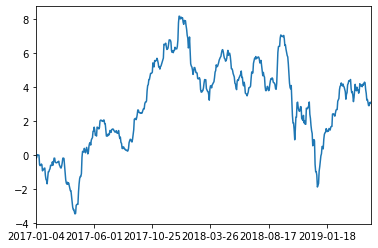

In [14]:
df_neutral.mean(axis=1).cumsum().plot()

# リスク回避

In [15]:
mean_risk_sensitive = np.mean(risk_sensitive_q, axis=1)
actions = np.where(mean_risk_sensitive > -2, 1, 0)
epi_rewards = (rewards * actions)

df_sensitive = pd.DataFrame(
    index=sorted(set(dates)), 
    columns=sorted(list(set(codes))))

for d, c, r in zip(dates, codes, epi_rewards):
    df_sensitive.loc[d, c] = r
df_sensitive = df_sensitive.fillna(0)

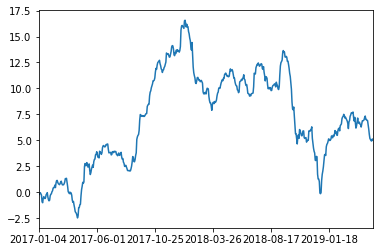

In [16]:
df_sensitive.mean(axis=1).cumsum().plot()

# リスク中立

## 期待値が正の場合のみ

In [17]:
# 平均
mean_thred_list = []
mean_list = []
mean_std_list = []
mean_win_list = []
mean_risk_neutral = np.mean(risk_neutral_q, axis=1)

for thred in np.arange(mean_risk_neutral.min(), mean_risk_neutral.max(), 0.1):
    actions = np.where(mean_risk_neutral > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    mean_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    mean_thred_list.append(thred)
    mean_list.append(mean)
    mean_std_list.append(std)

# median
median_thred_list = []
median_list = []
median_std_list = []
median_win_list = []
median_risk_neutral = np.median(risk_neutral_q, axis=1)
    
for thred in np.arange(median_risk_neutral.min(), median_risk_neutral.max(), 0.1):
    actions = np.where(median_risk_neutral > thred, 1, 0)
    epi_rewards = (rewards * actions)
    median = epi_rewards.mean()
    std = epi_rewards.std()
    median_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    median_thred_list.append(thred)
    median_list.append(median)
    median_std_list.append(std)

# sharpe ratio
sr_thred_list = []
sr_mean_list = []
sr_std_list = []
sr_win_list = []
sr = risk_neutral_q.mean(axis=1) / risk_neutral_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    sr_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    sr_thred_list.append(thred)
    sr_mean_list.append(mean)
    sr_std_list.append(std)

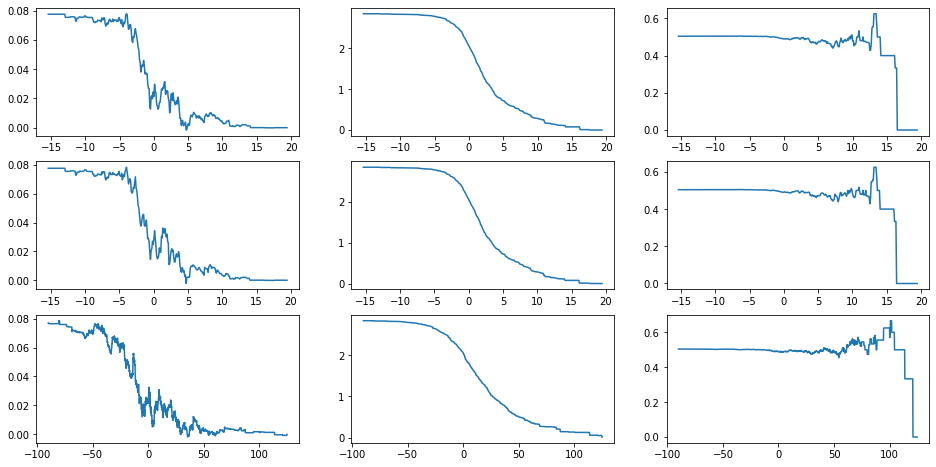

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8))
ax[0, 0].plot(mean_thred_list, mean_list)
ax[0, 1].plot(mean_thred_list, mean_std_list)
ax[0, 2].plot(mean_thred_list, mean_win_list)

ax[1, 0].plot(median_thred_list, median_list)
ax[1, 1].plot(median_thred_list, median_std_list)
ax[1, 2].plot(median_thred_list, median_win_list)

ax[2, 0].plot(sr_thred_list, sr_mean_list)
ax[2, 1].plot(sr_thred_list, sr_std_list)
ax[2, 2].plot(sr_thred_list, sr_win_list)

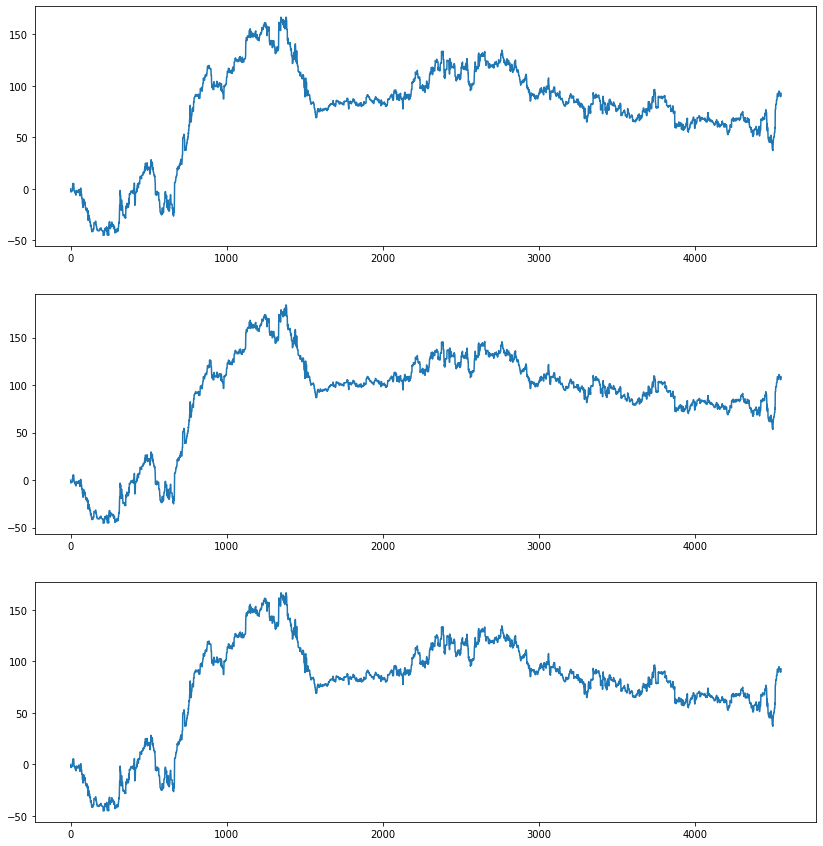

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(14, 15))
actions = np.where(np.mean(risk_neutral_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[0].plot(epi_rewards.cumsum())

actions = np.where(np.median(risk_neutral_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[1].plot(epi_rewards.cumsum())

actions = np.where(sr > 0, 1, 0)
epi_rewards = rewards * actions
ax[2].plot(epi_rewards.cumsum())

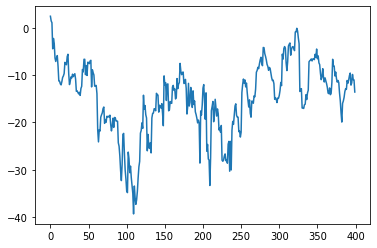

In [20]:
plt.plot(rewards[3200:3600].cumsum())

# risk_sensitive

In [21]:
# 平均
mean_thred_list = []
mean_list = []
mean_std_list = []
mean_win_list = []
mean_risk_sensitive = np.mean(risk_sensitive_q, axis=1)

for thred in np.arange(mean_risk_sensitive.min(), mean_risk_sensitive.max(), 0.1):
    actions = np.where(mean_risk_sensitive > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    mean_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    mean_thred_list.append(thred)
    mean_list.append(mean)
    mean_std_list.append(std)

# median
median_thred_list = []
median_list = []
median_std_list = []
median_win_list = []
median_risk_sensitive = np.median(risk_sensitive_q, axis=1)
    
for thred in np.arange(median_risk_sensitive.min(), median_risk_sensitive.max(), 0.1):
    actions = np.where(median_risk_sensitive > thred, 1, 0)
    epi_rewards = (rewards * actions)
    median = epi_rewards.mean()
    std = epi_rewards.std()
    median_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    median_thred_list.append(thred)
    median_list.append(median)
    median_std_list.append(std)

# sharpe ratio
sr_thred_list = []
sr_mean_list = []
sr_std_list = []
sr_win_list = []
sr = risk_sensitive_q.mean(axis=1) / risk_sensitive_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    sr_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    sr_thred_list.append(thred)
    sr_mean_list.append(mean)
    sr_std_list.append(std)

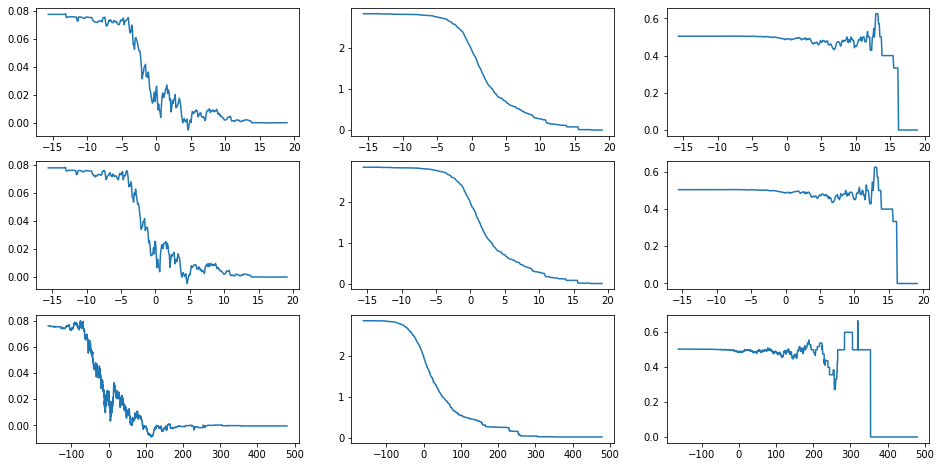

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8))
ax[0, 0].plot(mean_thred_list, mean_list)
ax[0, 1].plot(mean_thred_list, mean_std_list)
ax[0, 2].plot(mean_thred_list, mean_win_list)

ax[1, 0].plot(median_thred_list, median_list)
ax[1, 1].plot(median_thred_list, median_std_list)
ax[1, 2].plot(median_thred_list, median_win_list)

ax[2, 0].plot(sr_thred_list, sr_mean_list)
ax[2, 1].plot(sr_thred_list, sr_std_list)
ax[2, 2].plot(sr_thred_list, sr_win_list)

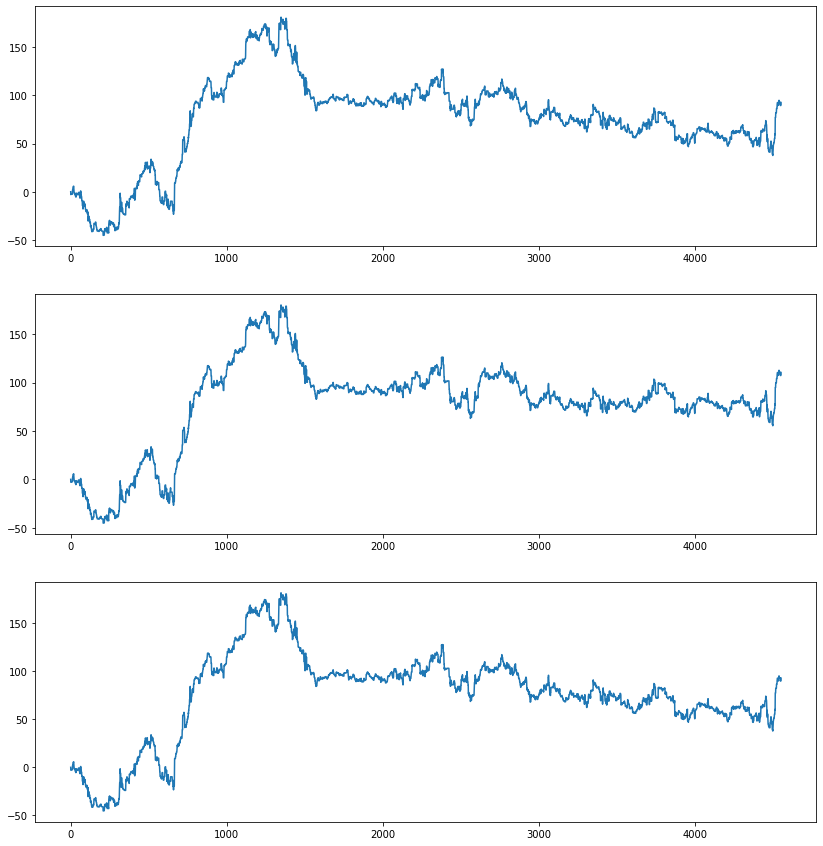

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(14, 15))
actions = np.where(np.mean(risk_sensitive_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[0].plot(epi_rewards.cumsum())

actions = np.where(np.median(risk_sensitive_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[1].plot(epi_rewards.cumsum())

actions = np.where(sr > 0, 1, 0)
epi_rewards = rewards * actions
ax[2].plot(epi_rewards.cumsum())

# risk_averse

In [24]:
# 平均
mean_thred_list = []
mean_list = []
mean_std_list = []
mean_win_list = []
mean_risk_averse = np.mean(risk_averse_q, axis=1)

for thred in np.arange(mean_risk_averse.min(), mean_risk_averse.max(), 0.1):
    actions = np.where(mean_risk_averse > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    mean_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    mean_thred_list.append(thred)
    mean_list.append(mean)
    mean_std_list.append(std)

# median
median_thred_list = []
median_list = []
median_std_list = []
median_win_list = []
median_risk_averse = np.median(risk_averse_q, axis=1)
    
for thred in np.arange(median_risk_averse.min(), median_risk_averse.max(), 0.1):
    actions = np.where(median_risk_averse > thred, 1, 0)
    epi_rewards = (rewards * actions)
    median = epi_rewards.mean()
    std = epi_rewards.std()
    median_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    median_thred_list.append(thred)
    median_list.append(median)
    median_std_list.append(std)

# sharpe ratio
sr_thred_list = []
sr_mean_list = []
sr_std_list = []
sr_win_list = []
sr = risk_averse_q.mean(axis=1) / risk_averse_q.std(axis=1)

for thred in np.arange(sr.min(), sr.max(), 0.1):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (rewards * actions)
    mean = epi_rewards.mean()
    std = epi_rewards.std()
    sr_win_list.append(sum(rewards * actions > 0) / sum(actions > 0))

    sr_thred_list.append(thred)
    sr_mean_list.append(mean)
    sr_std_list.append(std)

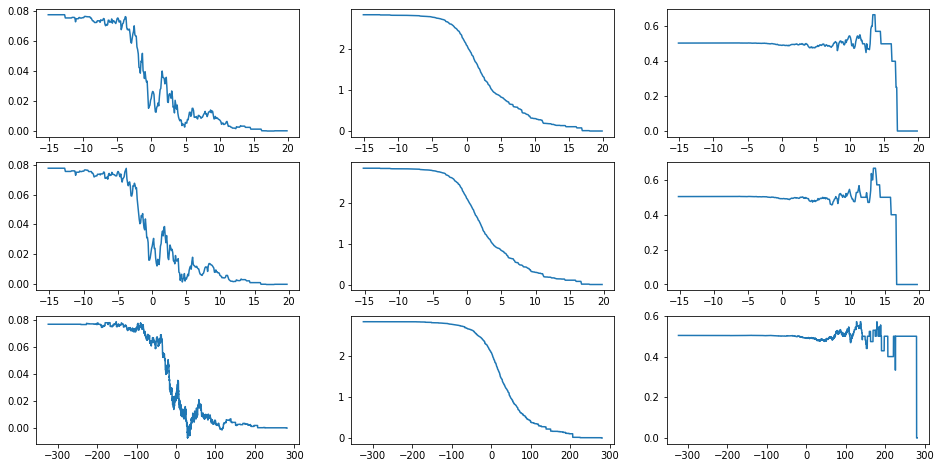

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8))
ax[0, 0].plot(mean_thred_list, mean_list)
ax[0, 1].plot(mean_thred_list, mean_std_list)
ax[0, 2].plot(mean_thred_list, mean_win_list)

ax[1, 0].plot(median_thred_list, median_list)
ax[1, 1].plot(median_thred_list, median_std_list)
ax[1, 2].plot(median_thred_list, median_win_list)

ax[2, 0].plot(sr_thred_list, sr_mean_list)
ax[2, 1].plot(sr_thred_list, sr_std_list)
ax[2, 2].plot(sr_thred_list, sr_win_list)

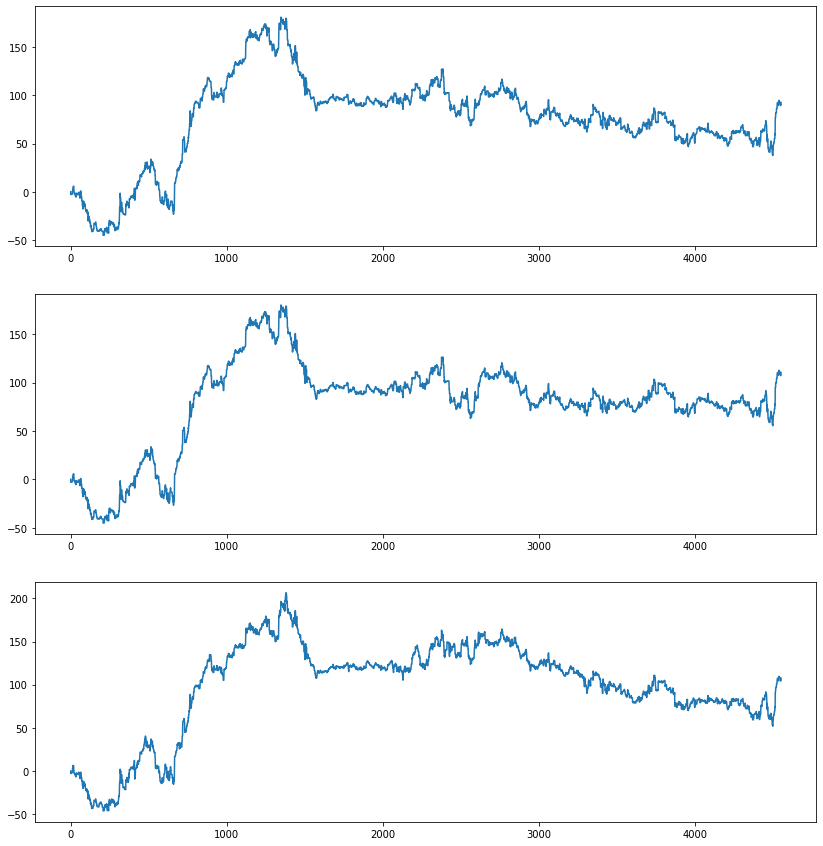

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(14, 15))
actions = np.where(np.mean(risk_sensitive_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[0].plot(epi_rewards.cumsum())

actions = np.where(np.median(risk_sensitive_q, axis=1) > 0, 1, 0)
epi_rewards = rewards * actions
ax[1].plot(epi_rewards.cumsum())

actions = np.where(sr > 0, 1, 0)
epi_rewards = rewards * actions
ax[2].plot(epi_rewards.cumsum())

# プロット

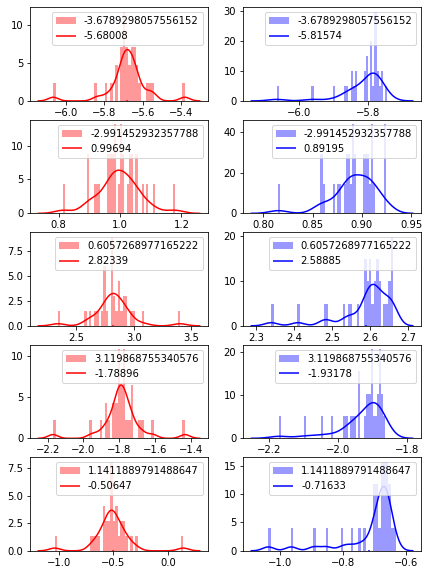

In [27]:
start = 0
N = 5
fig, ax = plt.subplots((N-start), 2, figsize=(7, (N-start)*2));

for i in range(start, N):    
    
    # 普通の分布
    sns.distplot(risk_neutral_q[i], bins=51, color='red', ax=ax[i - start][0], label=str(rewards[i]))
    mean = np.round(risk_neutral_q[i].mean(), 5)
    ax[i - start][0].vlines(mean, ymin=0, ymax=0.1, color='red', label=str(mean))

    # CVaR
    sns.distplot(risk_sensitive_q[i], bins=51, color='blue', ax=ax[i - start][1], label=str(rewards[i]))
    mean = np.round(risk_sensitive_q[i].mean(), 5)
    ax[i - start][1].vlines(mean, ymin=0, ymax=0.1, color='blue', label=str(mean))

    ax[i-start][0].legend()
    ax[i-start][1].legend()


Text(0, 0.5, 'volatility')

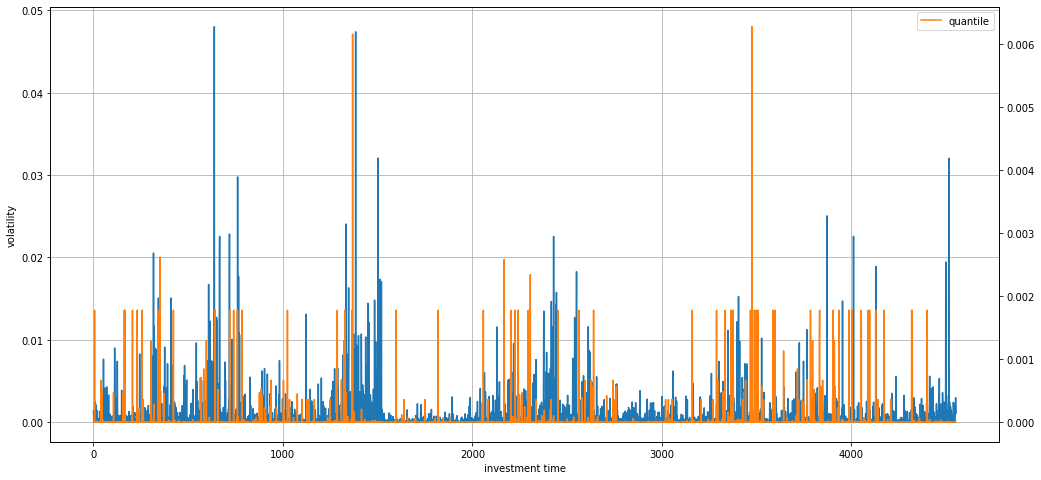

In [28]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot((rewards/100)**2, 'C0', label='reward')

ax2 = ax1.twinx()
var = (risk_neutral_q/100).var(axis=1)
ln2=ax2.plot(var, 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()
ax1.set_xlabel('investment time')
ax1.set_ylabel('volatility')

In [29]:
qq = ((rewards/100) - (var / 100))

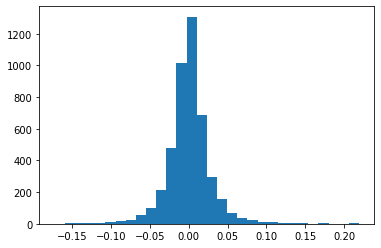

In [30]:
plt.hist(qq, bins=30)
plt.show()

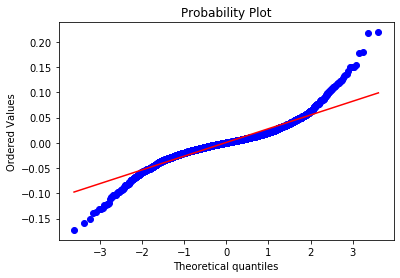

In [31]:
import scipy.stats as stats
stats.probplot(qq, dist="norm", plot=plt)
plt.show()

In [32]:
stats.jarque_bera(qq)

(7821.144813828551, 0.0)

Text(0, 0.5, 'volatility')

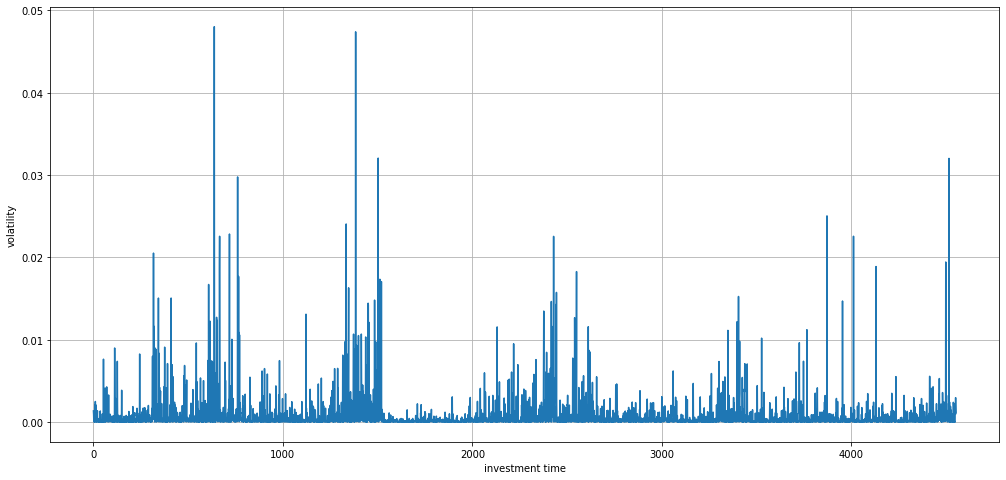

In [33]:
fig = plt.figure(figsize=(17, 8))
plt.plot((rewards/100)**2, 'C0', label='reward')
plt.grid(True)
plt.xlabel('investment time')
plt.ylabel('volatility')

Text(0, 0.5, 'volatility')

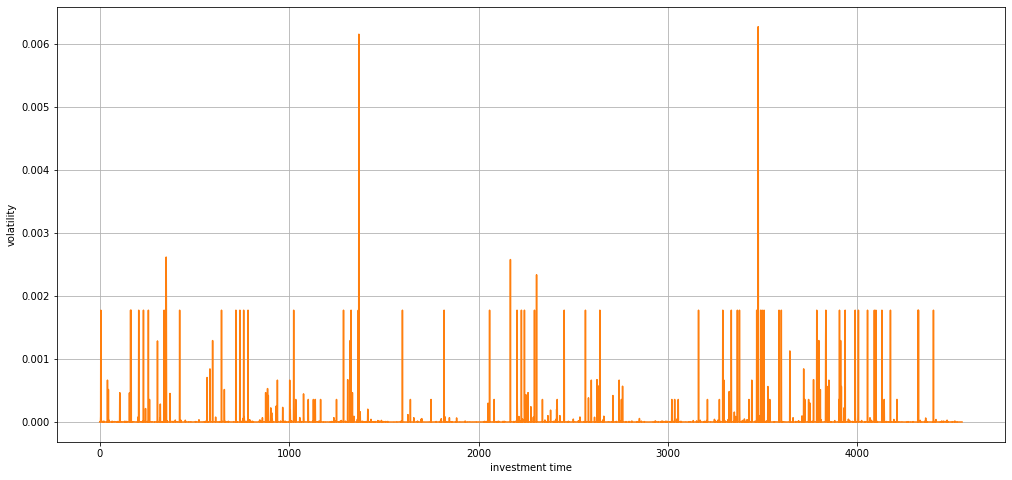

In [34]:
fig = plt.figure(figsize=(17, 8))
var= (risk_neutral_q/100).var(axis=1)

plt.plot(var, 'C1', label='quantile')

plt.grid(True)
plt.xlabel('investment time')
plt.ylabel('volatility')

# マイナスリスク

In [35]:
risk_rewards = rewards.copy()
# risk_rewards[risk_rewards > 0] = 0

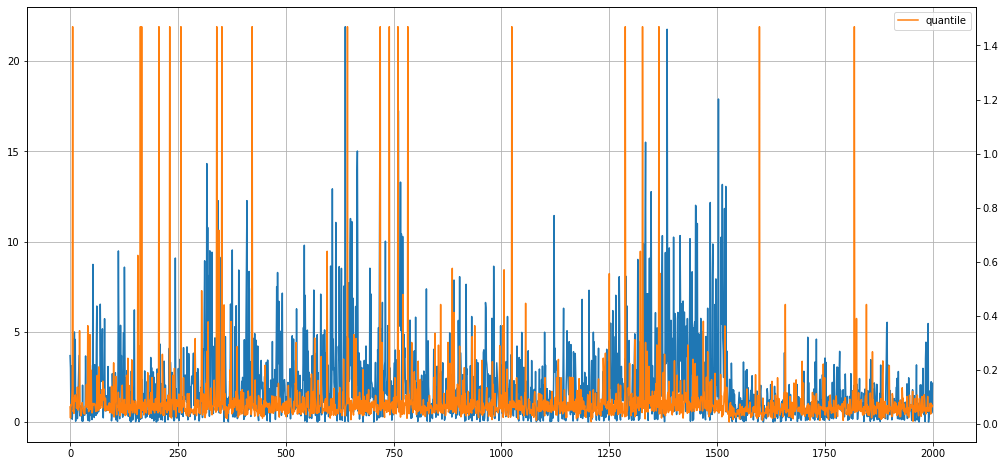

In [36]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot(np.abs(rewards[:2000]), 'C0', label='reward')

ax2 = ax1.twinx()
ln2=ax2.plot(np.abs(risk_sensitive_q.std(axis=1)[:2000]), 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()

In [37]:
return_rewards = rewards.copy()
return_rewards[return_rewards < 0] = 0

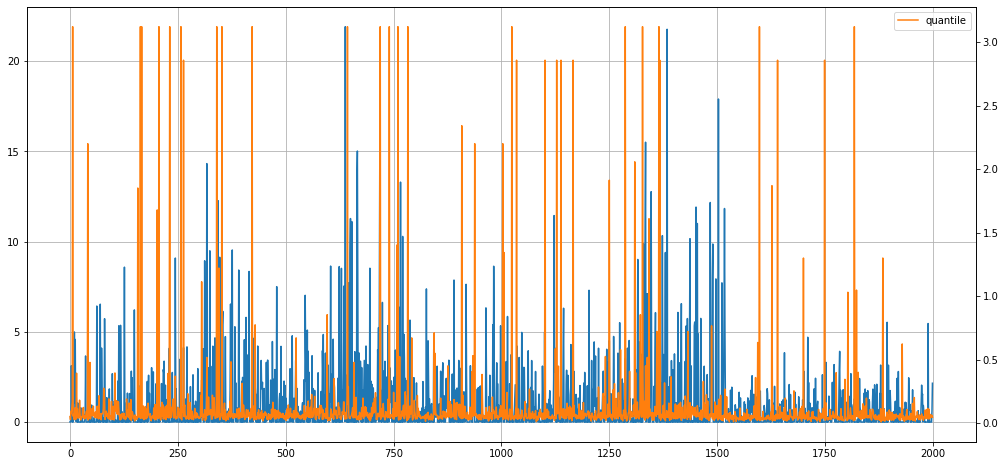

In [38]:
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)
ln1=ax1.plot(np.abs(return_rewards[:2000]), 'C0', label='reward')

ax2 = ax1.twinx()
ln2=ax2.plot(np.abs(risk_averse_q.std(axis=1)[:2000]), 'C1', label='quantile')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.grid(True)
plt.legend()